In [63]:
import pandas as pd
df=pd.read_csv("turkish_movie_sentiment_dataset.csv")

In [64]:
df.head()

,comment,film_name,point
0,\n Jean Reno denince zate...,Sevginin Gücü,"5,0"
1,\n Ekşın falan izlemek is...,Sevginin Gücü,"5,0"
2,\n Bu yapım hakkında öyle...,Sevginin Gücü,"5,0"
3,\n finali yeter... (sting...,Sevginin Gücü,"5,0"
4,\n Jean Reno..\r\nbu adam...,Sevginin Gücü,"5,0"


In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83227 entries, 0 to 83226
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   comment    83227 non-null  object
 1   film_name  83227 non-null  object
 2   point      83227 non-null  object
dtypes: object(3)
memory usage: 1.9+ MB


In [66]:
df.describe()

,comment,film_name,point
count,83227,83227,83227
unique,82456,7722,16
top,\n \n,Kapan,"4,0"
freq,300,92,19958


In [67]:
df.isnull().sum()

comment      0
film_name    0
point        0
dtype: int64

In [68]:
#Veri sütunundaki point değerlerindeki , yerine . koyularak ve 
#astype ile floata çevirerek point değerleri gerçek sayı oluyor.
df['point'] = df['point'].str.replace(",", ".").astype(float)

#Yeni label etiketi oluşturularak puanı 4 üzerindekiler için pozitiv,
#4'ten küçükler için negatif etiketi olarak ayırır.
df['label'] = df['point'].apply(lambda x: 'positive' if x >= 4 else 'negative')


#Comment sütunundakiler string çevirilir.
#Çünkü doğal dil işlemede "yorum" ve " yorum" farklı şekilde algılanabilir.
#Strip ile baş ve sonundaki boşluklarda temizlenir.
df['comment'] = df['comment'].astype(str).str.strip()

#Sadece kullanılacak comment ve label sütunlar seçilir.
#comment=girdi
#label=çıktı
df = df[['comment', 'label']]

In [69]:
#Doğal dil işlemede yapılan Metin temizleme (text preprocessing) kısmıdır.
#Noktalama işaretlerini tanımak için kullanılır.
import string

#Bir deseni bir diziyle eşleştirmek için kullanılır.
import re

#Stopwords gereksiz kelime tespiti için ve NLP için kullanılır.
import nltk
from nltk.corpus import stopwords

#Türkçe'deki "ve", "ama", "bir", "çok", "ile" gibi anlamı olmayan,
#modelin dikkatini dağıtan kelimeleri tanımlamak için kullanılır.
nltk.download('stopwords')
stop_words = set(stopwords.words('turkish'))

#Her bir yorumu işlemek için fonksiyon kullanırız.
def metin_temizleme(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)  # sayıları kaldır
    text = ''.join([ch for ch in text if ch not in string.punctuation])  # noktalama
    words = text.split()  #Kelimelere ayrılır.
    words = [word for word in words if word not in stop_words and len(word) > 2]
    return ' '.join(words)

df['clean_comment'] = df['comment'].apply(clean_text)


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/seymaaksu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [70]:
#TfidfVectorizer metinleri sayısal değerlere (matris)dönüştürür.
#Veriyi bir nevi ölçeklendirir.Her kelime birer özellik olur.
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf=TfidfVectorizer()

#Temizlenmiş yorumlarım bağımsız değişken olur.
#Bu yorumlara bakılarak tahmin elde edilir.
X=tfidf.fit_transform(df["clean_comment"])

#label (pozitif/negatif) değerim bağımlı değişkenim olur.
#Tahmin edilecek çıktımdır.
y=df['label']

In [71]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

In [72]:
#NLP sınıflandırma problemlerinde test etmek için kullanılan en yaygın
#denetimli algoritmadır.
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,confusion_matrix, classification_report

In [73]:
model=MultinomialNB()
model.fit(X_train,y_train)
y_predict=model.predict(X_test)

Doğruluk değeri : 0.7469662381352877
              precision    recall  f1-score   support

    negative       0.79      0.65      0.71      8020
    positive       0.72      0.84      0.77      8626

    accuracy                           0.75     16646
   macro avg       0.75      0.74      0.74     16646
weighted avg       0.75      0.75      0.74     16646



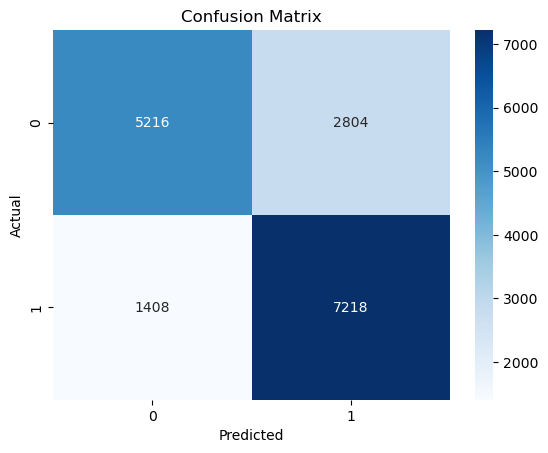

In [74]:
print("Doğruluk değeri :", accuracy_score(y_test,y_predict))
print(classification_report(y_test,y_predict))
cm = confusion_matrix(y_test, y_predict)

#Matris ile görselleştirilir.
import seaborn as sns
import matplotlib.pyplot as plt
sns.heatmap(cm,annot=True,fmt='d',cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [75]:
#Yeni gelen yoruma da  aynı işlemleri uygulamak için fonksiyon oluşturulur. 
def yeni_yorum_tahmini(text):
    cleaned = metin_temizleme(text)
    Tfidf=tfidf.transform([cleaned])
    return model.predict(Tfidf)[0]


print(yeni_yorum_tahmini("Bu filmi çok beğenemedim, harikayda değil gibidi..."))

    

negative


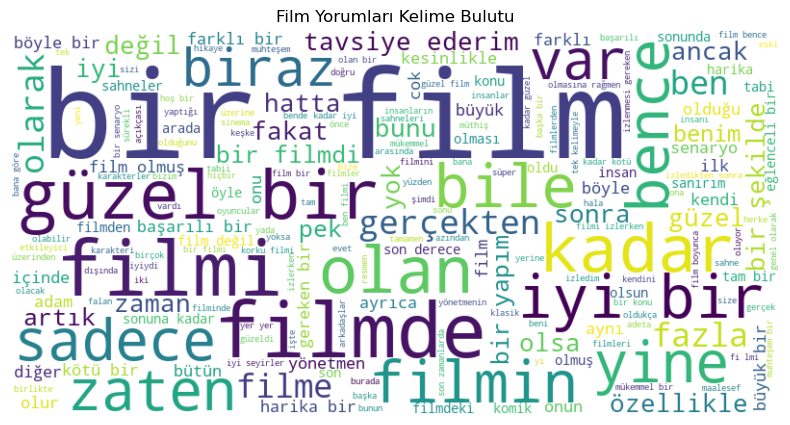

In [76]:
#Kullanıcı yorumlarında en çok geçen kelimeyi görsel şekilde ne kadar çok geçiyorsa o kadar
#büyük yazmayı sağlıyor.
from wordcloud import WordCloud #Kelime bulutu oluşturulur.

#Görsel oluşturmak için tek metin haline getirmemiz gerekir.
text = ' '.join(df['clean_comment'])

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
#text metni ile kelime bulutu oluşturması istendiği için nesnesi oluşturulur.

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Film Yorumları Kelime Bulutu")
plt.show()


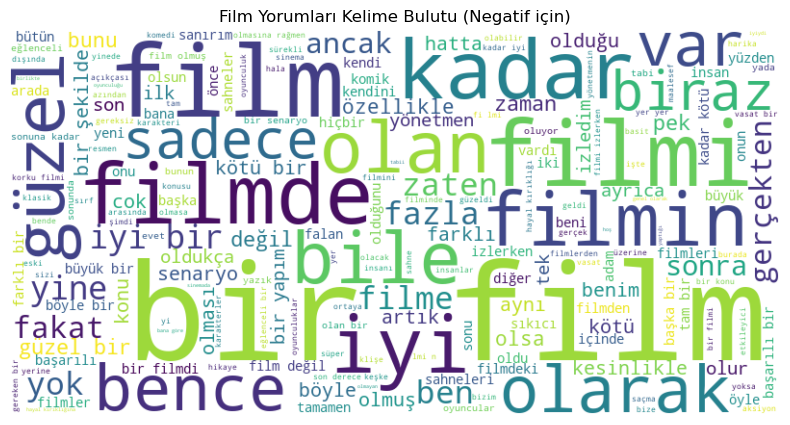

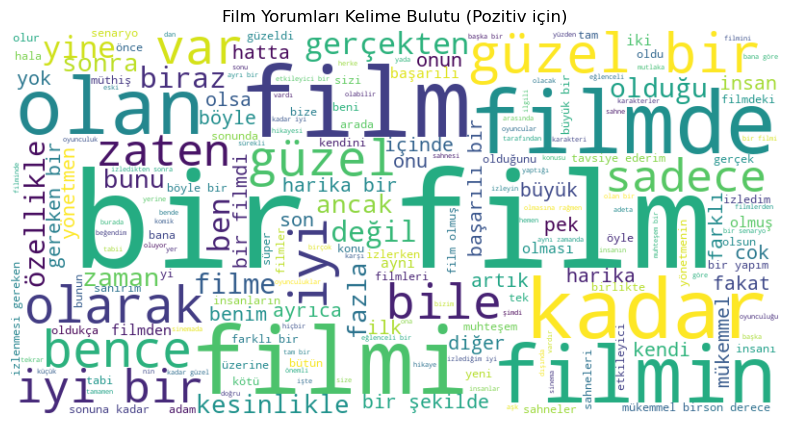

In [83]:
#Pozitif ve negatif etiketlerin ayrı ayrı kelinme bulunu oluşturmak istersek eğer:
pozitif_text= ''.join(df[df['label']=='positive']['clean_comment'])
negatif_text=''.join(df[df['label']=='negative']['clean_comment'])

wordcloud_negatif = WordCloud(width=800, height=400, background_color='white').generate(negatif_text)
#text metni ile kelime bulutu oluşturması istendiği için nesnesi oluşturulur.

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_negatif, interpolation='bilinear')
plt.axis("off")
plt.title("Film Yorumları Kelime Bulutu (Negatif için)")
plt.show()


wordcloud_pozitif = WordCloud(width=800, height=400, background_color='white').generate(pozitif_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_pozitif, interpolation='bilinear')
plt.axis("off")
plt.title("Film Yorumları Kelime Bulutu (Pozitif için)")
plt.show()